# AWS Re:Invent  Autogluon Workshop
### This workshop will demonstrate a machine learning problem solved by autogluon.
* Use the documentation of autogluon and the different tutorials [here](https://auto.gluon.ai/stable/index.html).

## Context
In this workshop will use the Time Series predictor of Autogluon to forecast the number of futures Covid cases in different countries.

In [2]:
# If running on your own computer please refer to AutoGluon installation instructions:
# https://auto.gluon.ai/stable/install.html
# This notebook assumes running in SageMaker Studio with "PyTorch 1.12 Python 3.8 CPU Optimized" kernel.
!pip3 install autogluon
!pip3 install ipywidgets


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Import the needed librairies
import pandas as pd
from matplotlib import pyplot as plt

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

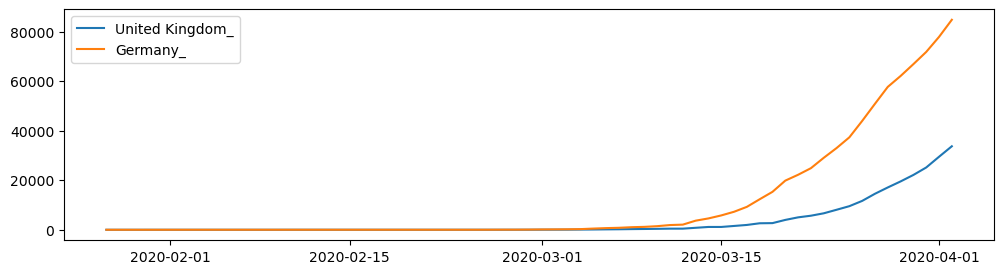

In [4]:
# We get the covid data 
df = pd.read_csv(
    "https://autogluon.s3-us-west-2.amazonaws.com/datasets/CovidTimeSeries/train.csv",
    parse_dates=["Date"],
)
# Creation of the train dataset using the TimeSeriesDataFrame.
train_data = TimeSeriesDataFrame.from_data_frame(
    df, # We give the data frame
    id_column="name", # We mention what are the id of the different time series (one for each country)
    timestamp_column="Date", # We pass the timestamp 
)

plt.figure(figsize=(12, 3))
for country in ["United Kingdom_", "Germany_"]:
    plt.plot(train_data.loc[country].iloc[5:], label=country)
plt.legend()

In [5]:
prediction_length = 5 # We will predict the next 5 days of covid cases

In [6]:
test_data = train_data.copy()
train_data = train_data.slice_by_timestep(-prediction_length) 
# We use the last 5 days as our testing set.

In [7]:
train_data.head()

ConfirmedCases
item_id      timestamp                 
Afghanistan_ 2020-03-29           120.0
             2020-03-30           170.0
             2020-03-31           174.0
             2020-04-01           237.0
             2020-04-02           273.0

In [9]:
predictor = TimeSeriesPredictor(
    path="autogluon-covidforecast", # Our saving path where will be all the models trained
    target="ConfirmedCases", # The label we want to predict from the data frame
    prediction_length=prediction_length, # the number of day we want to predict
    eval_metric="MAPE", # Our evaluation metric
)
predictor.fit(
    train_data=train_data, 
    tuning_data=test_data,
    time_limit=5*60 # we set 5 min for time purpose.
)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'MAPE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'default',
 'num_val_windows': 1,
 'prediction_length': 5,
 'random_seed': None,
 'target': 'ConfirmedCases',
 'time_limit': 300,
 'verbosity': 2}
Provided training data set with 1565 rows, 313 items (item = single time series). Average time series length is 5.0. Data frequency is 'D'.
Provided tuning data set with 22536 rows, 313 items. Average time series length is 72.0.
Multi-window backtesting is disabled (setting num_val_windows = 0)

It is recommended that all time series in train_data have length >= prediction_length + 1 (at least 6). Otherwise the predictor may not work as expected. 
Please reduce prediction_length or provide longer time series as train_data. 
AutoGluon will save models to autogluon-covidforecast/
AutoGluon wil

In [10]:
predictor.leaderboard(test_data, silent=True)
# We can compare the different models 

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.218326,-0.217660,10.805250,19.899423,2.147512,6
1,AutoETS,-0.225108,-0.224475,9.813838,18.956112,0.001705,4
2,Naive,-0.249334,-0.249334,0.361321,4.050023,0.003495,1
3,Theta,-0.259717,-0.259717,0.780625,21.399117,0.001789,3
4,SeasonalNaive,-0.543832,-0.543832,0.350070,0.369658,0.002974,2
5,DeepAR,-0.969409,-0.968578,0.981942,0.943311,91.967502,5


In [11]:
predictor.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


-0.21832629193166395

In [12]:
predictions = predictor.predict(train_data)

Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


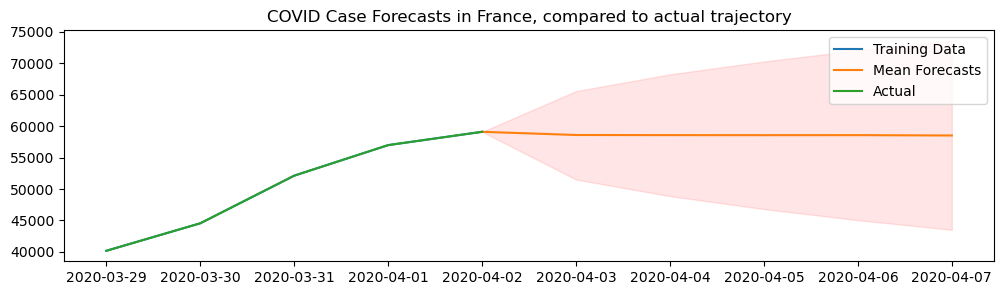

In [13]:
plt.figure(figsize=(12, 3))

ytrue = train_data.loc['France_']["ConfirmedCases"]
ypred = predictions.loc['France_']

# prepend the last value of true range to predicted range for plotting continuity
ypred.loc[ytrue.index[-1]] = [ytrue[-1]] * 10
ypred = ypred.sort_index()

ytrue_test = test_data.loc['France_']["ConfirmedCases"][-5:]

plt.plot(ytrue[-30:], label="Training Data")
plt.plot(ypred["mean"], label="Mean Forecasts")
plt.plot(ytrue_test, label="Actual")

plt.fill_between(
    ypred.index, ypred["0.1"], ypred["0.9"], color="red", alpha=0.1
)
plt.title("COVID Case Forecasts in France, compared to actual trajectory")
_ = plt.legend()